In [1]:
import numpy as np
import cv2
import scipy
import scipy.io
from sklearn.decomposition import FastICA
from tqdm import tqdm
from numpy import random

In [197]:
salinas = scipy.io.loadmat('salinas_full.mat')
X = salinas['salinas']
Y = salinas['salinas_gt']

In [198]:
ica = FastICA(n_components=3, random_state=0)
X_ica = ica.fit_transform(X)
X_ica.shape

(111104, 3)

In [199]:
X_ica = np.reshape(X_ica, [217,512,3])
X = np.zeros([512,217,3])
X[:,:,0] = np.transpose(X_ica[:,:,0])
X[:,:,1] = np.transpose(X_ica[:,:,1])
X[:,:,2] = np.transpose(X_ica[:,:,2])

In [200]:
X.shape

(512, 217, 3)

In [201]:
X[:,:,0] = X[:,:,0]/np.max(X[:,:,0])
X[:,:,1] = X[:,:,1]/np.max(X[:,:,1])
X[:,:,2] = X[:,:,2]/np.max(X[:,:,2])
np.max(X[:,:,2])

1.0

In [202]:
Y = np.transpose(np.reshape(Y,[217,512]))
cv2.imwrite(('../Desktop/%s.png' % 'Y'), Y*15)

True

In [8]:
img_w = 64 
img_h = 64  

 X=''
image_sets = X_ica
    
def rotate(xb,yb,angle):
    M_rotate = cv2.getRotationMatrix2D((img_w/2, img_h/2), angle, 1)
    xb = cv2.warpAffine(xb, M_rotate, (img_w, img_h))
    yb = cv2.warpAffine(yb, M_rotate, (img_w, img_h))
    return xb,yb
    
def blur(img):
    img = cv2.blur(img, (3, 3));
    return img
 
def add_noise(img):
    for i in range(25):
        temp_x = np.random.randint(0,img.shape[0])
        temp_y = np.random.randint(0,img.shape[1])
        img[temp_x][temp_y] = 1
    return img

In [9]:
def data_augment(xb,yb):
    if np.random.random() < 0.25:
        xb,yb = rotate(xb,yb,90)
    if np.random.random() < 0.25:
        xb,yb = rotate(xb,yb,180)
    if np.random.random() < 0.25:
        xb,yb = rotate(xb,yb,270)
    if np.random.random() < 0.25:
        xb = cv2.flip(xb, 1)  # flipcode > 0：沿y轴翻转
        yb = cv2.flip(yb, 1)
        
    if np.random.random() < 0.25:
        xb = blur(xb)
    
    if np.random.random() < 0.2:
        xb = add_noise(xb)
        
    return xb,yb

In [10]:
def creat_dataset(image_num, mode):
    print('creating dataset...')
    g_count = 0
#    for i in tqdm(range(1)):
    count = 0
        #src_img = cv2.imread('./data/src/' + image_sets[i])  # 3 channels
        #label_img = cv2.imread('./data/label/' + image_sets[i],cv2.IMREAD_GRAYSCALE)  # single channel
    src_img = X*255 #0-1
    label_img = Y
    X_height,X_width,_ = src_img.shape
    while count < image_num:
        random_width = random.randint(0, X_width - img_w - 1)
        random_height = random.randint(0, X_height - img_h - 1)
        src_roi = src_img[random_height: random_height + img_h, random_width: random_width + img_w,:]
        label_roi = label_img[random_height: random_height + img_h, random_width: random_width + img_w]
        if mode == 'augment':
            src_roi,label_roi = data_augment(src_roi,label_roi)
            
        visualize = np.zeros((32img_w,32img_h)).astype(np.uint8)
    #    visualize = np.zeros((32img_w,32img_h)).astype(np.uint8)
        visualize = label_roi *16-1
            
        cv2.imwrite(('../Desktop/Train/visualize/%d.png' % g_count),visualize)
        cv2.imwrite(('../Desktop/Train/src/%d.png' % g_count),src_roi)
        cv2.imwrite(('../Desktop/Train/label/%d.png' % g_count),label_roi)
        count += 1 
        g_count += 1

In [93]:
creat_dataset(5000, 'augment')#50

creating dataset...


In [75]:
from keras.datasets import mnist
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, UpSampling2D, Reshape, Permute, Activation
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [76]:
def SegNet():  
    model = Sequential()  
    #encoder  
    model.add(Conv2D(64,(3,3),strides=(1,1),input_shape=(img_w,img_h,3),padding='same',activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu'))  
    model.add(BatchNormalization())  
    model.add(MaxPooling2D(pool_size=(2,2)))  
    #(64,64)  
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    #(32,32)  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    #(16,16)  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    #(8,8)  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    #(4,4)  
    #decoder  
    model.add(UpSampling2D(size=(2,2)))  
    #(8,8)  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(UpSampling2D(size=(2, 2)))  
    #(16,16)  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(UpSampling2D(size=(2, 2)))  
    #(32,32)  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(UpSampling2D(size=(2, 2)))  
    #(64,64)  
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(UpSampling2D(size=(2, 2)))  
    #(128,128)  
    model.add(Conv2D(64, (3, 3), strides=(1, 1), input_shape=(3,img_w, img_h), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))  
    model.add(BatchNormalization())  
    model.add(Conv2D(n_label, (1, 1), strides=(1, 1), padding='same'))  
    model.add(Reshape((n_label,img_w*img_h)))  
    #axis=1和axis=2互换位置，等同于np.swapaxes(layer,1,2)  
    model.add(Permute((2,1)))  
    model.add(Activation('softmax'))  
    model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])  
    model.summary()  
    return model 

In [77]:
def get_train_val(val_rate = 0.25):
    train_url = []    
    train_set = []
    val_set  = []
    for pic in os.listdir(filepath + 'src'):
        train_url.append(pic)
    random.shuffle(train_url)
    total_num = len(train_url)
    val_num = int(val_rate * total_num)
    for i in range(len(train_url)):
        if i < val_num:
            val_set.append(train_url[i]) 
        else:
            train_set.append(train_url[i])
    return train_set,val_set
    
# data for training  
def generateData(batch_size,data=[]):  
    #print 'generateData...'
    while True:  
        train_data = []  
        train_label = []  
        batch = 0  
        for i in (range(len(data))): 
            url = data[i]
            batch += 1 
            #print (filepath + 'src/' + url)
            #img = load_img(filepath + 'src/' + url, target_size=(img_w, img_h))  
            img = load_img(filepath + 'src/' + url)
            img = img_to_array(img) 
            # print img
            # print img.shape  
            train_data.append(img)  
            #label = load_img(filepath + 'label/' + url, target_size=(img_w, img_h),grayscale=True)
            label = load_img(filepath + 'label/' + url, grayscale=True)
            label = img_to_array(label).reshape((img_w * img_h,))  
            # print label.shape  
            train_label.append(label)  
            if batch % batch_size==0: 
                #print 'get enough bacth!\n'
                train_data = np.array(train_data)  
                train_label = np.array(train_label).flatten()  
                #train_label = LabelEncoder.fit_transform(train_label)  
                train_label = to_categorical(train_label, num_classes=n_label)  
                train_label = train_label.reshape((batch_size,img_w * img_h,n_label))  
                yield (train_data,train_label)  
                train_data = []  
                train_label = []  
                batch = 0  

# data for validation 
def generateValidData(batch_size,data=[]):  
    #print 'generateValidData...'
    while True:  
        valid_data = []  
        valid_label = []  
        batch = 0  
        for i in (range(len(data))):  
            url = data[i]
            batch += 1  
            #img = load_img(filepath + 'src/' + url, target_size=(img_w, img_h))
            img = load_img(filepath + 'src/' + url)
            #print img
            #print (filepath + 'src/' + url)
            img = img_to_array(img)  
            # print img.shape  
            valid_data.append(img)  
            #label = load_img(filepath + 'label/' + url, target_size=(img_w, img_h),grayscale=True)
            label = load_img(filepath + 'label/' + url, grayscale=True)
            label = img_to_array(label).reshape((img_w * img_h,))  
            # print label.shape  
            valid_label.append(label)  
            if batch % batch_size==0:  
                valid_data = np.array(valid_data)  
                valid_label = np.array(valid_label).flatten()  
                #valid_label = LabelEncoder.fit_transform(valid_label)  
                valid_label = to_categorical(valid_label, num_classes=n_label)  
                valid_label = valid_label.reshape((batch_size,img_w * img_h,n_label))  
                yield (valid_data,valid_label)  
                valid_data = []  
                valid_label = []  
                batch = 0

In [79]:
EPOCHS = 50
BS = 25
n_label = 17
args = {'model':[]}
filepath = '../Desktop/Train/'
model = SegNet()  
modelcheck = ModelCheckpoint(args['model'],monitor='val_acc',save_best_only=True,mode='max')  
callable = [modelcheck]  
train_set,val_set = get_train_val()
train_numb = len(train_set)  
valid_numb = len(val_set)  
print ("the number of train data is",train_numb)  
print ("the number of val data is",valid_numb)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_655 (Conv2D)          (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_633 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_656 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_634 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_657 (Conv2D)          (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_635 (Bat (None, 32, 32, 128)     

In [80]:
H = model.fit(generateData(BS,train_set),steps_per_epoch=train_numb//BS,epochs=EPOCHS,
              validation_data=generateValidData(BS,val_set),validation_steps=valid_numb//BS)  

Epoch 1/50
150/150 [==============================] - 406s 3s/step - loss: 1.9302 - accuracy: 0.4293 - val_loss: 2.1747 - val_accuracy: 0.4555
Epoch 2/50
150/150 [==============================] - 372s 2s/step - loss: 1.1137 - accuracy: 0.6118 - val_loss: 1.3262 - val_accuracy: 0.5614
Epoch 3/50
150/150 [==============================] - 373s 2s/step - loss: 0.9491 - accuracy: 0.6492 - val_loss: 0.8981 - val_accuracy: 0.6640
Epoch 4/50
150/150 [==============================] - 374s 2s/step - loss: 0.8528 - accuracy: 0.6722 - val_loss: 0.8376 - val_accuracy: 0.6781
Epoch 5/50
150/150 [==============================] - 373s 2s/step - loss: 0.7923 - accuracy: 0.6848 - val_loss: 0.7947 - val_accuracy: 0.6864
Epoch 6/50
150/150 [==============================] - 373s 2s/step - loss: 0.7547 - accuracy: 0.6923 - val_loss: 0.7731 - val_accuracy: 0.6898
Epoch 7/50
150/150 [==============================] - 381s 3s/step - loss: 0.7305 - accuracy: 0.6964 - val_loss: 0.7560 - val_accuracy: 0.6933

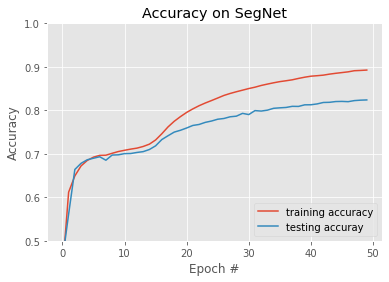

In [95]:
plt.plot(H.history['accuracy'], label = "training accuracy")
plt.plot(H.history['val_accuracy'], label = "testing accuray")
plt.ylim(0.5,1)
plt.title("Accuracy on SegNet")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc = 4)

In [83]:
train_acc = H.history['accuracy']
test_acc = H.history['val_accuracy']

In [162]:
# model.save("segnet.h5")
model.load_weights("segnet.h5")

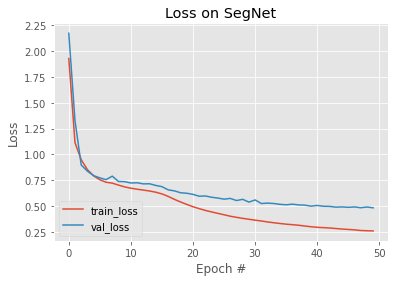

In [90]:
# plot the training loss and accuracy
#plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Loss on SegNet")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

In [96]:
H1 = model.fit(generateData(BS,train_set),steps_per_epoch=train_numb//BS,epochs=EPOCHS,
              validation_data=generateValidData(BS,val_set),validation_steps=valid_numb//BS)  

Epoch 1/50
150/150 [==============================] - 419s 3s/step - loss: 0.6383 - accuracy: 0.7631 - val_loss: 0.4800 - val_accuracy: 0.8107
Epoch 2/50
150/150 [==============================] - 377s 3s/step - loss: 0.4476 - accuracy: 0.8202 - val_loss: 0.4271 - val_accuracy: 0.8306
Epoch 3/50
150/150 [==============================] - 376s 3s/step - loss: 0.3764 - accuracy: 0.8470 - val_loss: 0.4174 - val_accuracy: 0.8358
Epoch 4/50
150/150 [==============================] - 376s 3s/step - loss: 0.3351 - accuracy: 0.8631 - val_loss: 0.4407 - val_accuracy: 0.8342
Epoch 5/50
150/150 [==============================] - 378s 3s/step - loss: 0.3091 - accuracy: 0.8735 - val_loss: 0.4174 - val_accuracy: 0.8404
Epoch 6/50
150/150 [==============================] - 378s 3s/step - loss: 0.2930 - accuracy: 0.8797 - val_loss: 0.4165 - val_accuracy: 0.8422
Epoch 7/50
150/150 [==============================] - 383s 3s/step - loss: 0.2833 - accuracy: 0.8836 - val_loss: 0.4072 - val_accuracy: 0.8454

In [97]:
model.save("segnet1.h5")

In [102]:
acc_train = np.zeros([100,1])
acc_train[0:50,0] = H.history['accuracy']
acc_train[50:100,0] = H1.history['accuracy']

acc_test = np.zeros([100,1])
acc_test[0:50,0] = H.history['val_accuracy']
acc_test[50:100,0] = H1.history['val_accuracy']

loss_train = np.zeros([100,1])
loss_train[0:50,0] = H.history['loss']
loss_train[50:100,0] = H1.history['loss']

loss_test = np.zeros([100,1])
loss_test[0:50,0] = H.history['val_loss']
loss_test[50:100,0] = H1.history['val_loss']

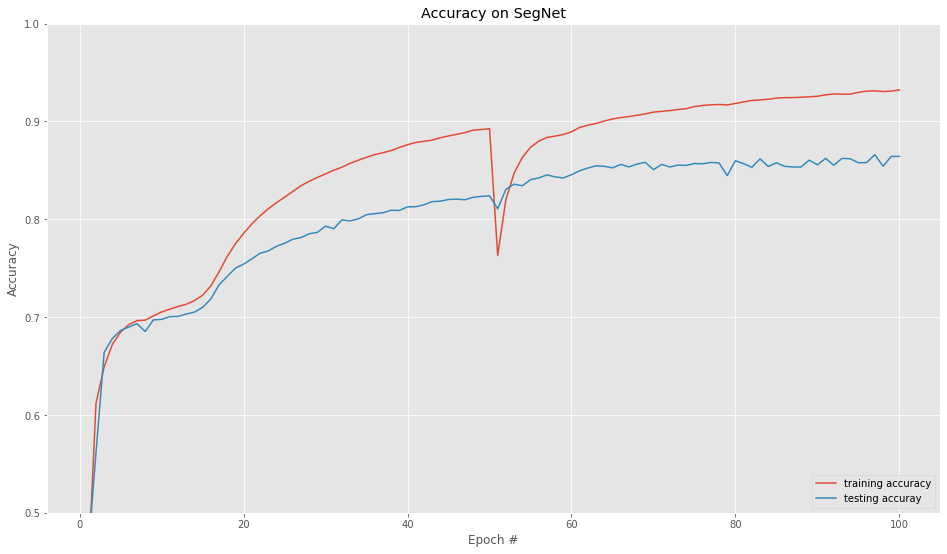

In [103]:
plt.figure(figsize = (16,9))
plt.plot(np.arange(0, 100)+1, acc_train, label = "training accuracy")
plt.plot(np.arange(0, 100)+1, acc_test, label = "testing accuray")
plt.ylim(0.5,1)
plt.title("Accuracy on SegNet")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc = 4)

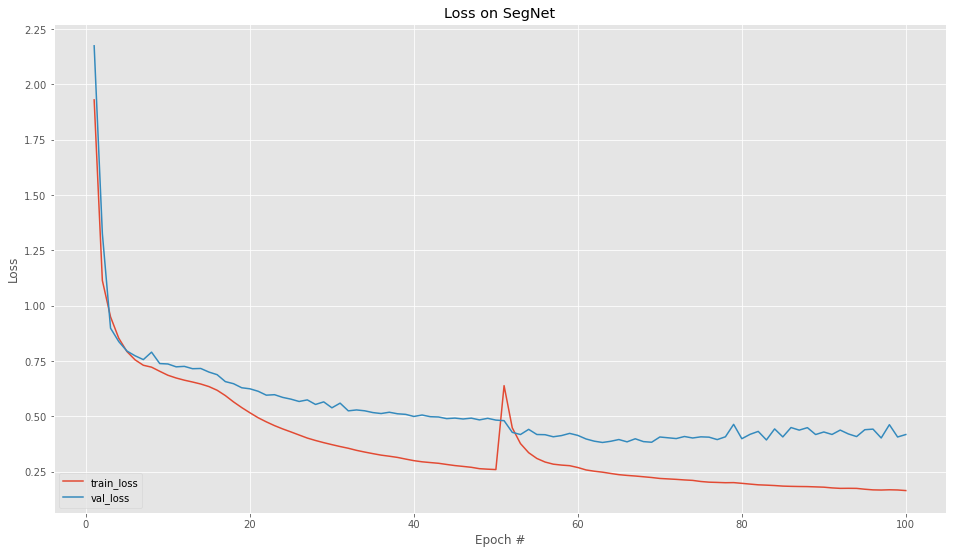

In [104]:
plt.figure(figsize = (16,9))
plt.plot(np.arange(0, 100)+1, loss_train, label="train_loss")
plt.plot(np.arange(0, 100)+1, loss_test, label="val_loss")
plt.title("Loss on SegNet")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [203]:
# load the trained convolutional neural network
print("[INFO] loading network...")
stride = 64
image_size = stride

    
image = X*255 
h,w,_ = image.shape
padding_h = (h//stride + 1) * stride 
padding_w = (w//stride + 1) * stride
padding_img = np.zeros((padding_h,padding_w,3),dtype=np.uint8)
padding_img[0:h,0:w,:] = image[:,:,:]
#padding_img = padding_img.astype("float")
#padding_img = img_to_array(padding_img)
print('src:',padding_img.shape)
mask_whole = np.zeros([padding_h,padding_w])
for i in range(padding_h//stride):
    for j in range(padding_w//stride):
        crop = padding_img[i*stride:i*stride+image_size,j*stride:j*stride+image_size,:]
        ch,cw,_ = crop.shape
        if ch != 64 or cw != 64:
            print('invalid size!')
            continue

        crop = np.expand_dims(crop, axis=0)
        #print 'crop:',crop.shape
        pred = model.predict_classes(crop)#,verbose=2)  
        #pred = labelencoder.inverse_transform(pred[0])  
        print(np.unique(pred))  
        pred = pred.reshape((64,64)).astype(np.uint8)
        #print 'pred:',pred.shape
        mask_whole[i*stride:i*stride+image_size,j*stride:j*stride+image_size] = pred[:,:]


cv2.imwrite('pred.png',mask_whole[0:h,0:w]*15)

[INFO] loading network...
src: (576, 256, 3)
[ 0  1  9 10 11]
[ 0  9 10]
[ 0  3  5  6  8  9 10 15]
[ 0  3  4  5  6  7  8  9 10]
[ 0  1  9 10]
[ 0  9 10]
[ 0  3  4  5  8  9 10 11]
[ 0  3  4  5  6  8  9 10]
[ 0  4  5  8  9 10]
[ 0  5  7  9 10 11 15 16]
[ 0  1  9 10 11]
[ 0  3  4  5  6  8  9 10]
[ 0  4  5  9 10 11]
[ 0  3  4  9 10 11]
[ 0  9 10 11]
[ 0  3  4  5  8  9 10]
[ 0  9 10 11]
[ 0  1  3  5  6  8  9 10 11]
[ 0  1  4  5  8  9 10 11]
[ 0  3  4  5  8  9 10]
[ 0  1  4  5  6  8  9 10 11]
[ 0  1  3  4  5  6  8  9 10 11]
[ 0  4  8  9 10 11]
[ 0  3  5  6  8  9 10]
[ 0  1  3  4  5  6  8  9 10]
[ 0  1  3  4  5  6  7  8  9 10 11]
[ 0  1  4  8  9 10 11]
[ 0  3  4  5  6  8  9 10]
[ 0  3  4  5  6  7  9 10]
[ 0  1  4  8  9 10 11]
[ 0  1  9 10]
[ 0  3  5  6  8  9 10]
[0 3]
[0 3]
[0 3]
[0 3]


True

In [168]:
mask_whole = mask_whole[0:h,0:w]
mask_whole = np.transpose(np.reshape(mask_whole.reshape(512*217,1),[217,512]))
cv2.imwrite('pred.png',mask_whole*15)

True

In [148]:
random.randint(5)

3

In [191]:
def noise(img):
    for i in range(len(img)):
        if np.random.random() < 0.07:
            Y[i,0] = 0
            continue
        if (np.random.random() < 0.08):
            m = np.min([16-Y[i,0], Y[i,0]])
            Y[i,0] = Y[i,0] + random.randint(m+1) * (-1)^(random.randint(2))
            continue
    return img

In [192]:
np.unique(Y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8)

In [193]:
np.min([5,3])

3

In [194]:
Y1 = noise(Y)

In [195]:
Y1 = np.transpose(np.reshape(Y1,[217,512]))
cv2.imwrite(('../Desktop/%s.png' % 'Y1'), Y1*15)

True